In [1]:
import os
import cv2
import sys
import hashlib
import numpy as np
import scipy.special as sp
import matplotlib
import matplotlib.pyplot as plt
import datetime  
from scipy import stats
# import scikit_posthocs as skp
# import seaborn as sns


import utils
from routine import Routine

%matplotlib inline

#in order to find where the tests are located
testing_dir = os.path.join('../randomness_testing/sp800_22_tests')
sys.path.append(testing_dir)

# determine if we are using Windows or Linux filing conventions and assign root folders
if sys.platform == 'win32':
    SCAPA_ROOT = os.path.join('Z:', os.sep, 'group')
    ORKNEY_ROOT = os.path.join('U:', os.sep)
else:
    SCAPA_ROOT = '/mnt/scapa4'
    ORKNEY_ROOT  ='/mnt/orkney1'

ORKNEY_TEAM = os.path.join(ORKNEY_ROOT, 'Clusters')
ORKNEY_PROJECT = os.path.join(ORKNEY_TEAM, 'RandomXtl')
ORKNEY_MASKRCNN = os.path.join(ORKNEY_PROJECT, 'MaskRCNN')
ORKNEY_DETECTED = os.path.join(ORKNEY_MASKRCNN, 'detected')
ORKNEY_TRAINING = os.path.join(ORKNEY_MASKRCNN, 'training')
ORKNEY_DATASETS = os.path.join(ORKNEY_TRAINING, 'datasets')
ORKNEY_LOGS = os.path.join(ORKNEY_TRAINING, 'logs')

ORKNEY_IMAGES = os.path.join(ORKNEY_PROJECT, 'images')
ORKNEY_RAW_IMGS = os.path.join(ORKNEY_IMAGES, 'raw_images')
ORKNEY_PART_IMGS = os.path.join(ORKNEY_IMAGES, 'partitioned')

ORKNEY_CV = os.path.join(ORKNEY_PROJECT, 'computer_vision')
ORKNEY_VIALS = os.path.join(ORKNEY_CV, 'vials')

ORKNEY_RANDOM = os.path.join(ORKNEY_PROJECT, 'random numbers')


IMG_EXTS = ['.img', '.bmp', '.tiff', '.jpg', '.png']

data = []



def lin2win(filepath):
    return filepath.replace('/mnt/scapa4', 'Z:').replace('/mnt/orkney1', 'U:').replace('/', '\\')

def win2lin(filepath):
    return filepath.replace('Z:', '/mnt/scapa4' ).replace('U:', '/mnt/orkney1').replace('\\', '/')

def load_string(image_path, version, bits_per_attribute):
    
    image_head, image_ext = os.path.splitext(image_path)
    image_title = os.path.basename(image_head)
    reaction_path = os.path.dirname(os.path.dirname(image_path))
    rxn_id = os.path.basename(reaction_path)
    exp_path = os.path.dirname(reaction_path)
    exp_id = os.path.basename(exp_path)
    cmpd_path = os.path.dirname(exp_path)
    cmpd_id = os.path.basename(cmpd_path)

    strings_output_dir = os.path.join(ORKNEY_RANDOM, 'rad-ang', cmpd_id, exp_id, rxn_id, image_title, 'strings',str(bits_per_attribute))
    strings_output_dir = os.path.join(ORKNEY_RANDOM, 'old method', cmpd_id, exp_id, rxn_id, image_title, 'strings' )
    strings_output_dir = os.path.join(ORKNEY_RANDOM, 'microstates mod', cmpd_id, exp_id, rxn_id, image_title, 'strings' )
    

    output_dir = os.path.join(strings_output_dir, 'all.txt')   
    string = open(output_dir,'r').read()
    return string

def join_rxn_idx(exp_strings):
    joined = ['' for i in range(len(exp_strings[0]))]
    for rdx, rxn in enumerate(exp_strings):
        for idx, image in enumerate(rxn):
            joined[idx] += image            
    return joined

def get_first_n(exp_strings, n, bits_per_attribute, m):
    short_en, short_def, short_str = [], [], []
    bits_per_xtl = bits_per_attribute*2
    for rdx, rxn in enumerate(exp_strings):
        img_en, img_def, img_string = [], [], []
        for idx, image in enumerate(rxn):
            num_xtls = int(len(image) / bits_per_xtl)
            img_string =image[::-1][:num_xtls*bits_per_xtl]
            short_bits = [int(i) for i in img_string]
            if num_xtls >= 20:
                apen_img, def_img = get_approximate_entropy(short_bits, m)
            else:
                apen_img, def_img = None, None
            img_en.append(apen_img)
            img_def.append(def_img)
        short_en.append(img_en)
        short_def.append(img_def)
        short_str.append(img_string)
    return short_en, short_def, short_str


def join_rxn_idx(exp_strings):
    joined = ['' for i in range(len(exp_strings[0]))]
    for rdx, rxn in enumerate(exp_strings):
        for idx, image in enumerate(rxn):
            joined[idx] += image            
    return joined

def get_first_n(exp_strings, n, bits_per_attribute, m):
    short_en, short_def, short_str = [], [], []
    bits_per_xtl = bits_per_attribute*2
    for rdx, rxn in enumerate(exp_strings):
        img_en, img_def, img_string = [], [], []
        for idx, image in enumerate(rxn):
            num_xtls = int(len(image) / bits_per_xtl)
            img_string =image[::-1][:num_xtls*bits_per_xtl]
            short_bits = [int(i) for i in img_string]
            if num_xtls >= 20:
                apen_img, def_img = get_approximate_entropy(short_bits, m)
            else:
                apen_img, def_img = None, None
            img_en.append(apen_img)
            img_def.append(def_img)
        short_en.append(img_en)
        short_def.append(img_def)
        short_str.append(img_string)
    return short_en, short_def, short_str

def get_phi(bits, m, n):
    if m == 0:
        return 0
    padded_bits = bits+bits[0:m-1]      #  augment the sequence with the m-1 initial bits
    counts = [0 for i in range(2**m)]
    for bdx in range(n):
        block = padded_bits[bdx:bdx+m]
        block_as_int = int(''.join([str(i) for i in block]), 2)
        counts[block_as_int] += 1
    Ci = [i/n for i in counts]
    phi_m = 0
    for i in Ci:
        if i > 0: phi_m += i*np.log(i)
    return phi_m
        
def get_approximate_entropy(bits, m):
    
    n = len(bits)
    phi_m = [get_phi(bits, m, n) for m in range(m, m+2)]
    ApEn = phi_m[0] - phi_m[1]
    apen_def = np.log(2) - ApEn
    return  ApEn, apen_def

def run_exp(exp_path, version, partitioning=[4,4,0.2], bits_per_attribute=4, m=0, reaction_range=[0,-1], image_range=[0,-1]):
    start, end = reaction_range
    rxns = sorted([i for i in os.listdir(exp_path) if 'reaction' in i.lower()])
    exp_apens, exp_defs, exp_strings = [], [], []
    for rxn in rxns[start:end]:
        rxn_path = os.path.join(exp_path, rxn)
        strings, rxn_apens, rxn_defs = run_rxn(rxn_path, version, partitioning, bits_per_attribute, m, image_range)
        exp_strings.append(strings)
        exp_apens.append(rxn_apens)
        exp_defs.append(rxn_defs)
    return exp_strings, exp_apens, exp_defs

def run_rxn(rxn_path, version, partitioning=[4,4,0.2], bits_per_attribute=4, m=0, image_range=[0,-1]):

    start, end = image_range
    image_dir = os.path.join(rxn_path, 'Images')
    image_names = sorted([i for i in os.listdir(image_dir)])
    rxn_apens, rxn_defs, rxn_strings = [], [], []

    for name in image_names[start: end]:      
        image_path= os.path.join(image_dir, name)
        sys.stdout.write('\r{} -> bits={}'.format(image_path, m))

        string = load_string(image_path, version, bits_per_attribute)
        rxn_strings.append(string)
        apen, deficit = get_approximate_entropy(string, m)
        rxn_apens.append(apen)
        rxn_defs.append(deficit)

    return rxn_strings, rxn_apens, rxn_defs

Cu1 = {'path': '/mnt/orkney1/Chemobot/crystalbot_imgs/CuSO4/180906a',
     'ver': '',
     'partitioning':[6,6,0.2],
     'image': [-2,-1],
     'reactions':[0,45],
      'cmpd': 'CuSO4'}
Cu2 = {'path': '/mnt/orkney1/Chemobot/crystalbot_imgs/CuSO4/180907d',
     'ver': '',
     'partitioning':[6,6,0.2],
     'image': [31,32],
     'reactions':[0,45],
      'cmpd': 'CuSO4'}
W1 = {'path': '/mnt/orkney1/Chemobot/crystalbot_imgs/W19/20180214-1',
     'ver': '',
     'partitioning':[4,4,0.2],
     'image': [78,79],
     'reactions':[0,45],
     'cmpd': 'W19'}
W2 = {'path': '/mnt/orkney1/Chemobot/crystalbot_imgs/W19/20180214-0',
     'ver': '',
     'partitioning':[6,6,0.2],
     'image': [20,21],
     'reactions':[0,45],
     'cmpd': 'W19'}
Co1 = {'path': '/mnt/orkney1/Chemobot/crystalbot_imgs/Co4/20180216-0',
     'ver': 'v2',
     'partitioning':[6,6,0.2],
     'image': [70,71],
     'reactions':[0,30],
      'cmpd': 'Co4'}
Co2 = {'path': '/mnt/orkney1/Chemobot/crystalbot_imgs/Co4/20180219-0',
     'ver': 'v2',
     'partitioning':[6,6,0.2],
     'image': [51,52],
     'reactions':[0,45],
      'cmpd': 'Co4'}

cmap=plt.get_cmap('Set1')

In [7]:

for m in range(1,5):
    for exp in [Cu1]:#, W2, Co1, Co2]:
        print(m, exp['cmpd'])
        exp_path = exp['path']
        version = exp['ver']
        exp_path = lin2win(exp_path)
        partitioning = exp['partitioning']
        reaction_range = exp['reactions']
        image_range = exp['image']

        bits_per_attribute = 1
        exp_strings, exp_apens, exp_defs = run_exp(exp_path, version, partitioning = partitioning, bits_per_attribute=bits_per_attribute,
                                                       m=m, reaction_range=reaction_range, image_range=image_range)


        n=50
#         short_en, short_def, short_string = get_first_n(exp_strings, n, bits_per_attribute, m)

        data_dict = {'exp path':exp_path, 'bits per attr': bits_per_attribute, 'm': m, 'reaction range':reaction_range, 
                     'image range': image_range, 'strings':exp_strings, 'apens':exp_apens, 'defs':exp_defs,
                     'partitioning':partitioning, 
                     'exp': exp['cmpd']}

        data.append(data_dict)

1 CuSO4
U:\Chemobot\crystalbot_imgs\CuSO4\180906a\reaction_45\Images\027.png -> bits=12 CuSO4
U:\Chemobot\crystalbot_imgs\CuSO4\180906a\reaction_45\Images\027.png -> bits=23 CuSO4
U:\Chemobot\crystalbot_imgs\CuSO4\180906a\reaction_45\Images\027.png -> bits=34 CuSO4
U:\Chemobot\crystalbot_imgs\CuSO4\180906a\reaction_45\Images\027.png -> bits=4

In [8]:
print('data index\tcmpd\tbits per attr\tm\treaction range\t\timage range\t\tcrystals')
for idx, d in enumerate(data):
    cmpd = d['exp path'].split('\\')[-2]
    print('{}\t\t{}\t\t{}\t{}\t{}\t\t\t{}'.format(idx, cmpd, d['bits per attr'], d['m'], d['reaction range'], 
                                                    d['image range']))



data index	cmpd	bits per attr	m	reaction range		image range		crystals
0		Co4		1	1	[0, 30]			[70, 71]
1		Co4		1	2	[0, 30]			[70, 71]
2		Co4		1	3	[0, 30]			[70, 71]
3		Co4		1	4	[0, 30]			[70, 71]
4		Co4		1	1	[0, 30]			[70, 71]
5		Co4		1	2	[0, 30]			[70, 71]
6		Co4		1	3	[0, 30]			[70, 71]
7		Co4		1	4	[0, 30]			[70, 71]
8		CuSO4		1	1	[0, 45]			[-2, -1]
9		CuSO4		1	2	[0, 45]			[-2, -1]
10		CuSO4		1	3	[0, 45]			[-2, -1]
11		CuSO4		1	4	[0, 45]			[-2, -1]


In [20]:
compound = 'CuSO4'

data_to_write = data[8:11]
print(type(data_to_write))
import pickle as pkl
description = 'CuSO4-m=(1-4)-entropy'

filename = './data/{}.p'.format(description)
pkl.dump(data_to_write, open(filename, 'wb'))


<class 'list'>


In [13]:
# description = 'CuSO4-m=(1-4)-entropy'
# filename = './data/{}.p'.format(description)
# import pickle as pkl
# CuSO4_data = pkl.load(open(filename, 'rb'))
# # W19_data = 
# for data in CuSO4_data:
#     print(data['m'])
# Co4_data[0].keys()
# all_data = []
# for dataset in [CuSO4_data, W19_data[:3], Co4_data]:
#     for miniset in dataset:
#         all_data.append(miniset)


m1s = all_data[0], all_data[3], all_data[6]
m2s = all_data[1], all_data[4], all_data[7]
m3s = all_data[2], all_data[5], all_data[8]

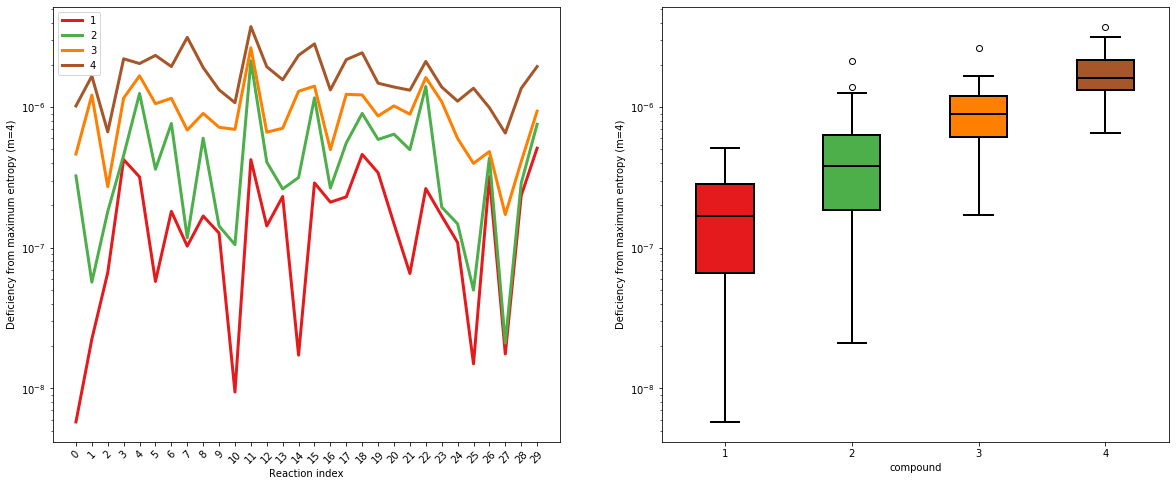

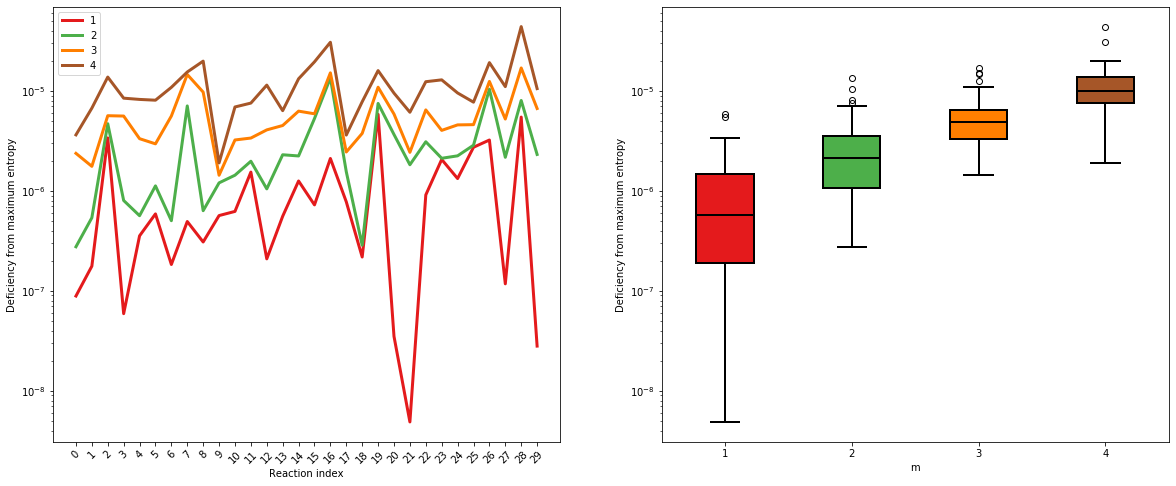

In [18]:
##### this looks at one compounds with various m values
dataset_idx = 8
dataset_count = 4

colors=[cmap(1.*i/dataset_count) for i in range(dataset_count)]

fig, ax = plt.subplots(1,2, figsize=(20,8))
bps = []
for i, color in zip(range(dataset_idx, dataset_idx+dataset_count), colors):
    this_data = [i[0] for i in data[i]['defs'][:30] if i[0] != None]
    ax[0].plot(this_data, label=data[i]['m'], linewidth=3, color=color)
    bps.append(this_data)
    
bplot = ax[1].boxplot(bps, patch_artist=True)

ax[1].set_yscale('log') 
ax[1].set_xlabel('compound')
# ax[1].set_xticklabels(labels=['CuSO4', 'W19', 'Co4'])

for patch, color in zip(bplot['boxes'], colors):
    patch.set(color='k', linewidth=2)
    patch.set_facecolor(color)
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bplot[element], color='k', linewidth=2)


# ax[1].set_title('{} bits per xtl for n={} largest crystals in reaction'.format(data[i]['bits per attr']*2, data[i]['first']['n']))
ax[1].set_ylabel('Deficiency from maximum entropy (m={})'.format(data[i]['m']))
ax[0].set_yscale('log')
ax[0].legend(loc='best')
ax[0].set_xlabel('Reaction index')
ax[0].set_ylabel('Deficiency from maximum entropy (m={})'.format(data[i]['m']))
# ax[0].set_title('{} bits per xtl for n={} largest crystals in reaction'.format(data[i]['bits per attr']*2, data[i]['first']['n']))
ax[0].set_xticks(range(30))
ax[0].set_xticklabels(labels=range(30), rotation=45)
plt.savefig('CuSO4 m-values.svg')
plt.show()

##### this looks at one compounds with various m values
dataset_idx = 4
dataset_count = 4

colors=[cmap(1.*i/dataset_count) for i in range(dataset_count)]

fig, ax = plt.subplots(1,2, figsize=(20,8))
bps = []
for i, color in zip(range(dataset_idx, dataset_idx+dataset_count), colors):
    this_data = [i[0] for i in data[i]['defs'][:30] if i[0] != None]
    ax[0].plot(this_data, label=data[i]['m'], linewidth=3, color=color)
    bps.append(this_data)
    
bplot = ax[1].boxplot(bps, patch_artist=True)

ax[1].set_yscale('log') 
ax[1].set_xlabel('m')
# ax[1].set_xticklabels(labels=['CuSO4', 'W19', 'Co4'])

for patch, color in zip(bplot['boxes'], colors):
    patch.set(color='k', linewidth=2)
    patch.set_facecolor(color)
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bplot[element], color='k', linewidth=2)


# ax[1].set_title('{} bits per xtl for n={} largest crystals in reaction'.format(data[i]['bits per attr']*2, data[i]['first']['n']))
ax[1].set_ylabel('Deficiency from maximum entropy'.format(data[i]['m']))
ax[0].set_yscale('log')
ax[0].legend(loc='best')
ax[0].set_xlabel('Reaction index')
ax[0].set_ylabel('Deficiency from maximum entropy'.format(data[i]['m']))
# ax[0].set_title('{} bits per xtl for n={} largest crystals in reaction'.format(data[i]['bits per attr']*2, data[i]['first']['n']))
ax[0].set_xticks(range(30))
ax[0].set_xticklabels(labels=range(30), rotation=45)
plt.savefig('Co4 m-values.svg')
plt.show()



              1             2             3
1 -1.000000e+00  3.467605e-02  1.090252e-07
2  3.467605e-02 -1.000000e+00  6.015126e-13
3  1.090252e-07  6.015126e-13 -1.000000e+00
F_onewayResult(statistic=31.75511285669661, pvalue=9.627578543090796e-12)


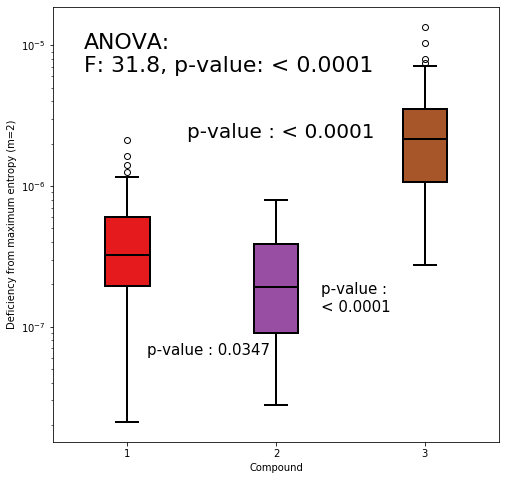

In [125]:
#### this looks at one compound, with different bits per attribute
from scipy import stats
import scikit_posthocs as skp

dataset_count = 3

colors=[cmap(1.*i/dataset_count) for i in range(dataset_count)]
dataset_idx = 0
this_dataset = m2s
fig, ax = plt.subplots(figsize=(8,8))
bps = []
for i, color in zip(range(3), colors):
    this_data = [i[0] for i in this_dataset[i]['defs'[:30]] if i[0] != None]
#     ax[0].plot(this_data, label=this_dataset[i]['exp'], linewidth=3, color=color)
    bps.append(this_data)
    
bplot = ax.boxplot(bps, patch_artist=True)

ax.set_yscale('log') 
ax.set_xlabel('compound')
# ax[1].set_xticklabels(labels=['CuSO4', 'W19', 'Co4'])

for patch, color in zip(bplot['boxes'], colors):
    patch.set(color='k', linewidth=2)
    patch.set_facecolor(color)
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bplot[element], color='k', linewidth=2)

cuw = stats.ttest_ind(bps[1], bps[2])
kruskal = stats.kruskal(*bps)
dunn = skp.posthoc_dunn(bps)
anova = stats.f_oneway(*bps)
print(dunn)
print(anova)

# ax[1].set_title(''.format(data[i]['bits per attr']*2, this_dataset[i]['first']['n']))
ax.set_ylabel('Deficiency from maximum entropy (m={})'.format(this_dataset[i]['m']))
ax.set_yscale('log')
# ax[0].legend(loc='best')
ax.set_xlabel('Compound')
# ax[0].set_ylabel('Deficiency from maximum entropy (m={})'.format(this_dataset[i]['m']))
# # ax[0].set_title('{} bits per xtl for n={} largest crystals in reaction'.format(this_dataset[i]['bits per attr']*2, this_dataset[i]['first']['n']))
# ax[0].set_xticks(range(50))
# ax[0].set_xticklabels(labels=range(50), rotation=45)

# # ax[1].annotate('stat = {:.2f};\np = {:.2f}'.format(*ttest), xy=(0.42,0.8), xycoords='axes fraction', size=14)
folder = './data'
os.makedirs(folder, exist_ok=True)
# name = '{}-bits-{}-m-{}-first-{}'.format(this_dataset[dataset_idx*dataset_count]['exp'],this_dataset[dataset_idx*dataset_count]['bits per attr']*2, 
#                                          this_dataset[dataset_idx*dataset_count]['m'], this_dataset[dataset_idx*dataset_count]['first']['n'])
# plt.savefig('{}.svg'.format(os.path.join(folder, name)))

ax.annotate('p-value : {:.4f}'.format(dunn[1][2]), xy=(0.21, 0.2), xycoords='axes fraction', size=15)
ax.annotate('p-value : < 0.0001'.format(dunn[1][3]), xy=(0.3, 0.7), xycoords='axes fraction', size=20)
ax.annotate('p-value : \n< 0.0001'.format(dunn[2][3]), xy=(0.6, 0.3), xycoords='axes fraction', size=15)
ax.annotate('ANOVA:\nF: {:.1f}, p-value: < 0.0001'.format(anova[0], anova[1]), xy=(0.07, 0.85), xycoords='axes fraction', size=22)

plt.savefig('{}.png'.format(os.path.join(folder, 'm2s')))
plt.savefig('{}.svg'.format(os.path.join(folder, 'm2s')))


plt.show()


In [5]:
#### this compares datasets to identical reactions across experimental runs


# plt.style.use('ggplot')
dataset_idx = 7
fig, ax = plt.subplots(1,2, figsize=(20,8))
bps = []
colors = ['goldenrod', 'cornflowerblue', 'darkseagreen']
dataset_count = 2
for i, color in zip(range(dataset_idx*dataset_count, dataset_count*(dataset_idx+1)), colors):
    this_data = [i[0] for i in data[i]['first']['def'] if i[0] != None]
    ax[0].plot(this_data, label=data[i]['exp'], linewidth=3, color=color)
    bps.append(this_data)
    
bplot = ax[1].boxplot(bps, patch_artist=True)

ax[1].set_yscale('log') 
ax[1].set_xlabel('compound')
ax[1].set_xticklabels(labels=['CuSO4', 'W19', 'Co4'])

for patch, color in zip(bplot['boxes'], colors):
    patch.set(color='k', linewidth=2)
    patch.set_facecolor(color)
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bplot[element], color='k', linewidth=2)


ax[1].set_title('{} bits per xtl for n={} largest crystals in reaction'.format(data[i]['bits per attr']*2, data[i]['first']['n']))
ax[1].set_ylabel('Deficiency from maximum entropy (m={})'.format(data[i]['m']))
ax[0].set_yscale('log')
ax[0].legend(loc='best')
ax[0].set_xlabel('Reaction index')
ax[0].set_ylabel('Deficiency from maximum entropy (m={})'.format(data[i]['m']))
ax[0].set_title('{} bits per xtl for n={} largest crystals in reaction'.format(data[i]['bits per attr']*2, data[i]['first']['n']))
ax[0].set_xticks(range(50))
ax[0].set_xticklabels(labels=range(50), rotation=45)

ax[1].annotate('stat = {:.2f};\np = {:.2f}'.format(*ttest), xy=(0.42,0.8), xycoords='axes fraction', size=14)
folder = './data'
os.makedirs(folder, exist_ok=True)
name = '{}-bits-{}-m-{}-first-{}'.format(data[dataset_idx*dataset_count]['exp'],data[dataset_idx*dataset_count]['bits per attr']*2, 
                                         data[dataset_idx*dataset_count]['m'], data[dataset_idx*dataset_count]['first']['n'])
plt.savefig('{}.svg'.format(os.path.join(folder, name)))
plt.savefig('{}.png'.format(os.path.join(folder, name)))

plt.show()

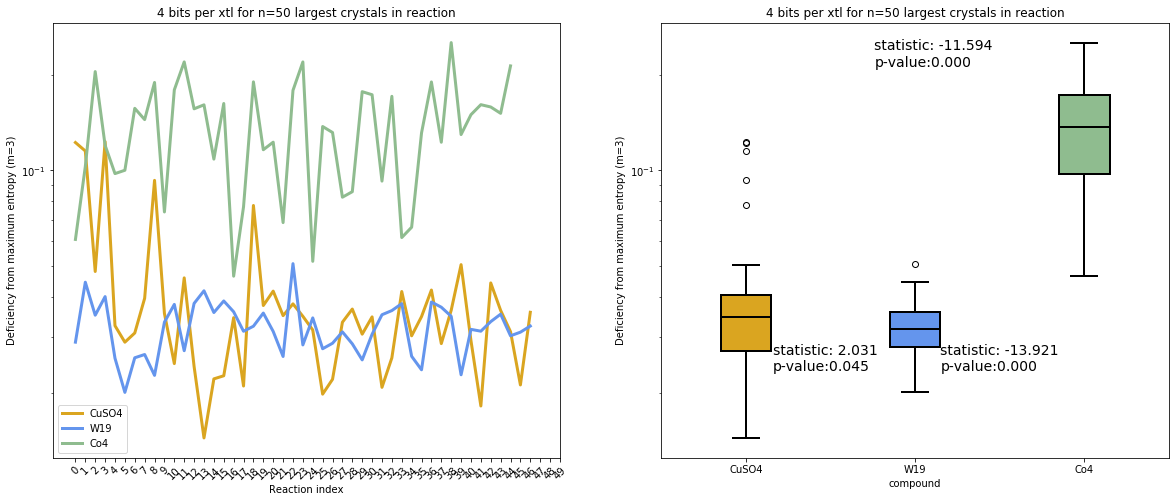

In [8]:
# print(data[3])

# plt.style.use('ggplot')
dataset_idx = 1
fig, ax = plt.subplots(1,2, figsize=(20,8))
bps = []
colors = ['goldenrod', 'cornflowerblue', 'darkseagreen']
dataset_count = 3
for i, color in zip(range(dataset_idx*dataset_count, dataset_count*(dataset_idx+1)), colors):
    this_data = [l[0] for l in data[i]['first']['def'] if l[0] != None]   
    ax[0].plot(this_data, label=data[i]['exp'], linewidth=3, color=color)
    bps.append(this_data)
    
bplot = ax[1].boxplot(bps, patch_artist=True)



for patch, color in zip(bplot['boxes'], colors):
    patch.set(color='k', linewidth=2)
    patch.set_facecolor(color)
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bplot[element], color='k', linewidth=2)

ax[1].set_yscale('log') 
ax[1].set_xlabel('compound')
ax[1].set_xticklabels(labels=['CuSO4', 'W19', 'Co4'])
ax[1].set_title('{} bits per xtl for n={} largest crystals in reaction'.format(data[i]['bits per attr']*2, data[i]['first']['n']))
ax[1].set_ylabel('Deficiency from maximum entropy (m={})'.format(data[i]['m']))

ax[0].set_yscale('log')
ax[0].legend(loc='best')
ax[0].set_xlabel('Reaction index')
ax[0].set_ylabel('Deficiency from maximum entropy (m={})'.format(data[i]['m']))
ax[0].set_title('{} bits per xtl for n={} largest crystals in reaction'.format(data[i]['bits per attr']*2, data[i]['first']['n']))
ax[0].set_xticks(range(50))
ax[0].set_xticklabels(labels=range(50), rotation=45)

kruskal = stats.kruskal(*bps)
krustal_sf = ['{:.1f}'.format(kruskal[0]), '{:.2e}'.format(kruskal[1])]
dunn = skp.posthoc_dunn(bps)

t12, t13, t23 = stats.ttest_ind(bps[0], bps[1]), stats.ttest_ind(bps[0], bps[2]), stats.ttest_ind(bps[1], bps[2])

t12 = 'statistic: {:.3f}\np-value:{:.3f}'.format(*t12)
t13 = 'statistic: {:.3f}\np-value:{:.3f}'.format(*t13)
t23 = 'statistic: {:.3f}\np-value:{:.3f}'.format(*t23)

ax[1].annotate('{}'.format(t12), xy=(0.22,0.2), xycoords='axes fraction', size=14)
ax[1].annotate('{}'.format(t13), xy=(0.42,0.9), xycoords='axes fraction', size=14)
ax[1].annotate('{}'.format(t23), xy=(0.55,0.2), xycoords='axes fraction', size=14)


folder = './data'
os.makedirs(folder, exist_ok=True)
name = 'All-bits-{}-m-{}-first-{}'.format(data[dataset_idx*dataset_count]['bits per attr']*2, 
                                         data[dataset_idx*dataset_count]['m'], data[dataset_idx*dataset_count]['first']['n'])
plt.savefig('{}.svg'.format(os.path.join(folder, name)))
plt.savefig('{}.png'.format(os.path.join(folder, name)))

plt.show()

In [138]:
path = r'U:\Clusters\RandomXtl\MaskRCNN\detected\W19\20180214-1\Reaction_018\Image_079\[4,4,0.2]\good_masks'
image_path = r'U:\Clusters\RandomXtl\MaskRCNN\detected\W19\20180214-1\Reaction_018\Image_079\Image_079.png'
image = cv2.imread(image_path)
bg = np.zeros(image.shape[:2])
mask_names = os.listdir(path)
for mask_name in mask_paths:
    t, b, l, r = [int(i) for i in  mask_name.split(';')[1].split('.')[0][1:-1].split(',')]
    mask_path = os.path.join(path, mask_name)
    mask= cv2.imread(mask_path, 0)
    bg[t:b, l:r] = mask
cv2.imwrite(r'U:\Clusters\RandomXtl\MaskRCNN\detected\W19\20180214-1\Reaction_018\Image_079\[4,4,0.2]\background.png', bg)

10;(362,406,794,855).png 362 406 794 855
10;(366,396,767,797).png 366 396 767 797
10;(369,420,584,635).png 369 420 584 635
10;(374,407,829,871).png 374 407 829 871
10;(382,417,698,738).png 382 417 698 738
10;(388,424,639,697).png 388 424 639 697
10;(396,446,733,776).png 396 446 733 776
10;(399,445,891,952).png 399 445 891 952
10;(402,432,840,893).png 402 432 840 893
10;(402,434,819,861).png 402 434 819 861
10;(419,448,652,693).png 419 448 652 693
10;(425,454,690,718).png 425 454 690 718
10;(429,498,581,632).png 429 498 581 632
10;(431,464,845,901).png 431 464 845 901
10;(440,473,632,666).png 440 473 632 666
10;(443,478,676,709).png 443 478 676 709
10;(445,475,760,801).png 445 475 760 801
10;(452,516,684,742).png 452 516 684 742
10;(466,514,829,883).png 466 514 829 883
10;(472,518,771,824).png 472 518 771 824
10;(492,522,598,631).png 492 522 598 631
10;(497,538,751,793).png 497 538 751 793
10;(500,528,871,904).png 500 528 871 904
10;(504,536,815,850).png 504 536 815 850
10;(512,562,637,

9;(533,561,363,406).png 533 561 363 406
9;(544,587,412,464).png 544 587 412 464
9;(553,588,591,646).png 553 588 591 646


True